In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 05, ASTR 596: Fundamentals of Data Science


## Sampling and MCMC

### Gautham Narayan 
##### <gsn@illinois.edu>

Borrowing heavily from David Kirkby and Adam Mantz this week

## Recap: Markov Chains

* We've come up with a model, an objective/loss/likelihood function and some priors
* Now we actually want to evaluate the posterior $P(\theta|D)$
    * analytically is too hard, so we draw samples (i.e. **Monte Carlo**) 
        * convert messy integrals to sums over the samples 
* Simple Monte Carlo was wasteful because we don't want to draw samples over all parameter space
    * one way to make it more efficient was make samples that are correlated with each other
        * keep sampling in regions of high probability, don't sample in regions without
        * Markov Chains are series of samples where every sample only depends on the previous one

* Want to setup the problem so the frequency of samples in some region of width $dx$ **is proportional** to some function of $x$
* There are two ways to do this:

    * **Inverse Transform sampling** - too restrictive, because functions must be invertible
    * Rejection sampling - general purpose
* If we're using rejection sampling to pick samples on our Markov Chain, we're doing **Markov Chain Monte Carlo** with **Metropolis Hastings** as our sampling strategy
    * The **equilibrium** state of this chain is the stationary distribution of samples we desire
    

## In-class exercise 1: Inverse Transform Sampling

We deal with exponential distributions a lot in astrophysics. 

This distribution has $p(x)=\lambda e^{-\lambda x}$ and $F(x)=1-e^{-\lambda x}$ for $x\geq0$.

The quantile function is, therefore, $F^{-1}(P) = -\ln(1-P)/\lambda$.

In [2]:
# Here's some code for the inverse tranform
# it accepts a vector x, that is hopefully exponentially distributed and the argument for an exponential lam
# it then plots the vector and the distribution
# RUN THIS

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def inv_trans(x, lam):
    hist = plt.hist(x, bins=50, density=True)
    xs = np.linspace(0.0, 10.0/lam, 100)
    pdf = lam * np.exp(-lam*xs)
    pdfline = plt.plot(xs, pdf, 'r', lw=2)
    plt.xlabel(r'x', fontsize=22)
    plt.ylabel(r'P(x)', fontsize=22);

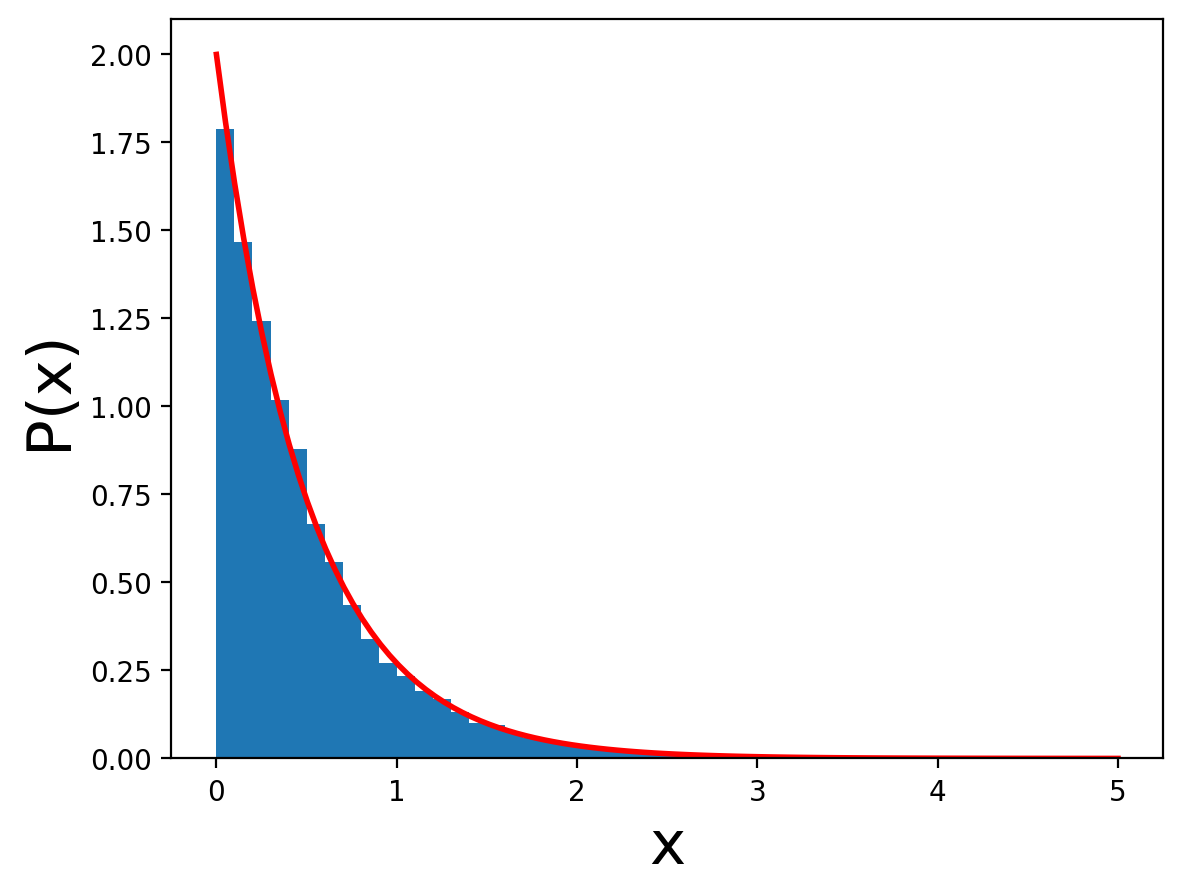

In [3]:
# for lam = 2., draw a 10000 random samples from a ** unform distribution **
# and use inverse CDF to convert to samples from a exponential distribution
# then use the inv_trans code to histogram your samples and overplot the distribution.

## draw random numbers from uniform distribution

lamb = 2

rand_un = np.random.uniform(0,1,10000)

## convert to samples from exp. distribution

def F(P):
    return -np.log(1-P)/lamb

inv_cdf = F(rand_un)

## inv_trans code to hist

inv_trans(inv_cdf,lamb)

## In-class exercise 2: A Full MCMC example with affine-invariant MC (i.e. `emcee`)

* Based on the paper by [Goodman and Weare](https://msp.org/camcos/2010/5-1/p04.xhtml)

* implemented in `emcee`

* many walkers simultaneously generating correlated Markov Chains

* **Affine Invariance** - efficiency not impacted by any linear (aka affine) transformation of the parameter space

This is one of a class of methods that evolve an *ensemble* of states rather than a single state.
After convergence, the ensemble can be regarded as a set of samples from the target distribution.

This approach provides some of the benefits of running multiple chains - but remember that these are not *independent* chains!

### The Goodman-Weare method

The algorithm for moving each point in the ensemble is:
1. Randomly pick a different point from the ensemble (total size $N$).
2. Propose a move in the direction of that point, by the distance between them multiplied by a random from this distribution:
$g(z) \propto \frac{1}{\sqrt z}; ~ \frac{1}{2}\leq z \leq 2$
3. Accept or reject the move based on the ratio of posterior densities multiplied by $z^{N-1}$.

Note that there is some magic in the density $g$. We are not free to choose just any function.

This algorithm is relatively easy to use - there is no tuning required and it's straightforward to parallelize.

Important cautions:
* if the ensemble is not started in a region of high probability, convergence will be **extremely** slow. Y
* as the walkers are not independent, the Gelman-Rubin convergence criterion doesn't apply
* assessing convergence visually is not always straightforward

# In class exercise - Using `emcee` to deal with the Hogg data problem

Same idea as Hogg data in the homework - we have some x, y data with outliers, but rather than use the Huber loss (which was a bit ad hoc)
we'll define a mixture likelihood and then use affine-invariant MCMC to sample the posterior. Critically, this will not have a tuning step! 

In [4]:
# RUN THIS

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from scipy import optimize

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'


# we'll create x, y, error values
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

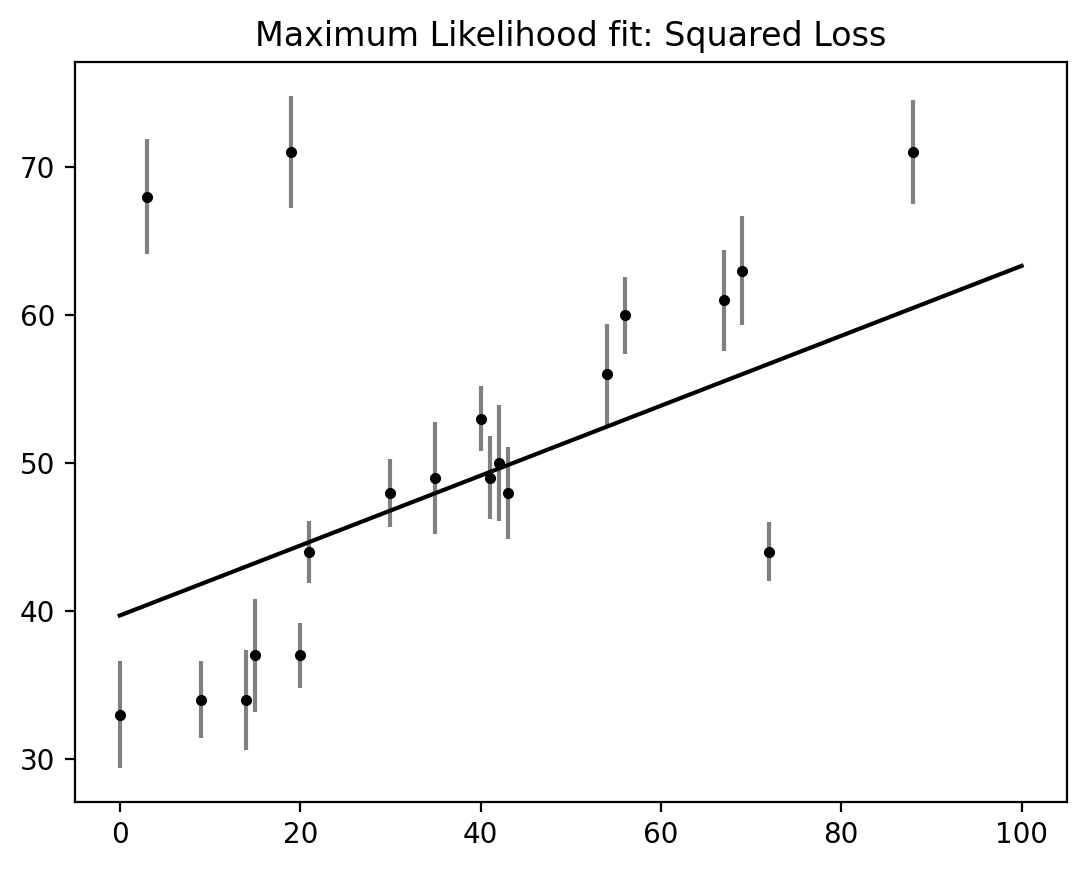

In [5]:
# RUN THIS

# just as before, we can define a simple chisquared function

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Maximum Likelihood fit: Squared Loss');

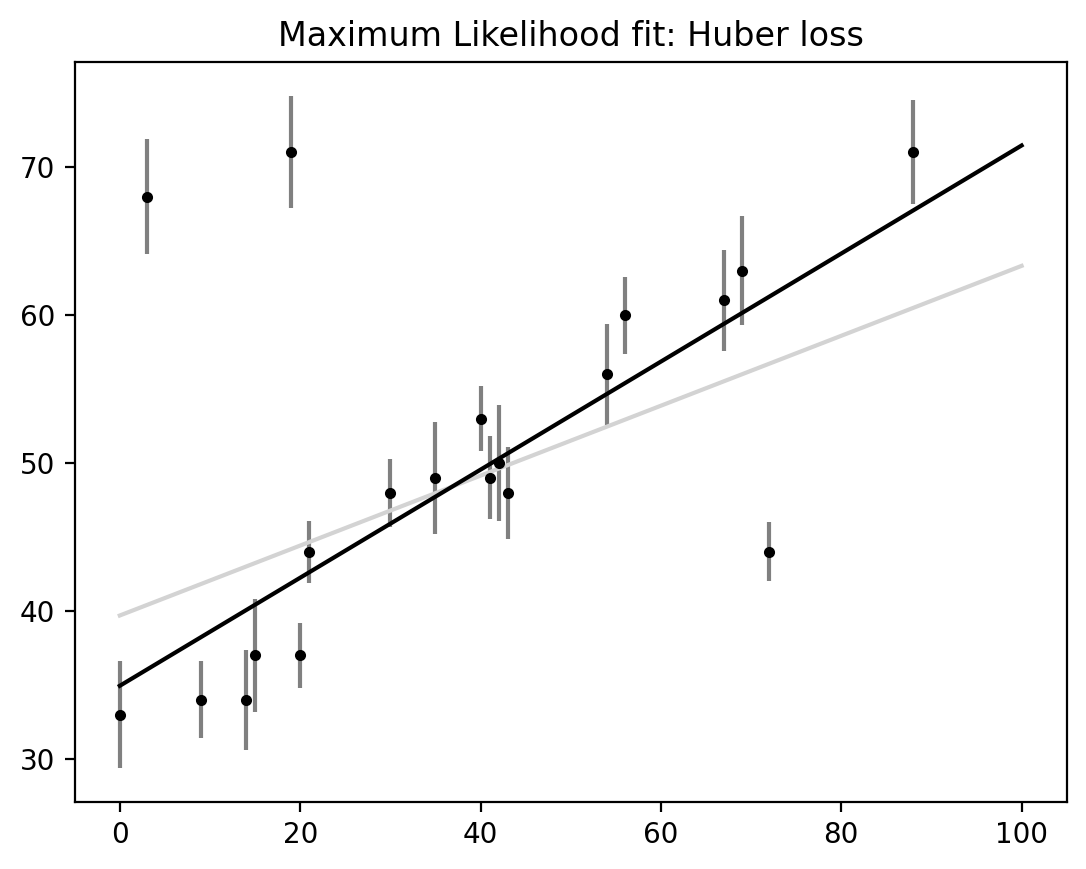

In [6]:
# RUN THIS

# we can also make a Huber loss function as before and get a fit that is more resilient to outliers

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Huber loss');

The Bayesian approach to accounting for outliers generally involves *modifying the model* so that the outliers are accounted for. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers.

One option is to choose a mixture between a signal and a background:

$$
\begin{array}{ll}
p(\{x_i\}, \{y_i\},\{e_i\}~|~\theta,\{g_i\},\sigma,\sigma_b) = & \frac{g_i}{\sqrt{2\pi e_i^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2e_i^2}\right] \\
&+ \frac{1 - g_i}{\sqrt{2\pi \sigma_B^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_B^2}\right]
\end{array}
$$

What we've done is expanded our model with some nuisance parameters: $\{g_i\}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. $g_i=0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter, or its value can be set at a sufficiently high number, say 50.

This model is a mixture of two Gaussians and is something we'll use a lot when we have multiple underlying populations that we want to model at the same time. We generally call these Gaussian mixture models, because we're really super creative. 

Our model is much more complicated now: it has 22 parameters rather than 2, but the majority of these can be considered nuisance parameters, which can be marginalized-out in the end, just as we marginalized (integrated) over $p$ in the Billiard example.  Let's construct a function which implements this likelihood. As in the previous post, we'll use the [emcee](https://emcee.readthedocs.io/en/stable/) package to explore the parameter space.

To actually compute this, we'll start by:
* defining the model (done implicitly) 
* functions describing our likelihood function (done above) 
* our prior (we'll make this up)
* and posterior (defined once we have likelihood and prior)

And then you get to use `emcee` to sample.

In [15]:
# DO THIS

# A. first you need to define a prior 
# there is a basic choice for prior ( i.e. g_i has to be between 0 and 1)
# we'll store the g_i in theta[2:] 
# your prior should be to check if 0 < theta[2:] < 1 - if it is, return 0. If not return -inf

def log_prior(theta):
    #g_i needs to be between 0 and 1
    
    if (all(theta[:2]>0) and all(theta[:2]<1)):
        return 0
        
    else: 
        return -np.inf
                                 
 
# B. Then you need to define a likelihood function
# the likelihood function is the same as we write above, except now as a log
def log_likelihood(theta, x, y, e, sigma_B):
    
    # this is the residual
    dy = y - theta[0] - theta[1] * x
    
    # this is again forcing the g_i to be within 0 and 1
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    
    # you should write two log-likelihood terms to implement the sum in the above formula
    # as logL1 and logL2
    
    logL1 = np.log(g/np.sqrt(2*np.pi*e**2))-(huber_loss(x)-y)**2/(2*e**2) ## take log of part before the exponential on each
    
    logL2 = np.log((1-g)/np.sqrt(2*np.pi*sigma_B**2))-(huber_loss(x)-y)**2/(2*sigma_B**2)
    
    # we have the sum of two PDFs that we took the log of
    # to do this when we write those PDFs itself as logs, we can use np.logaddexp
    return np.sum(np.logaddexp(logL1, logL2))


# C. Finally, you need to define the posterior
def log_posterior(theta, x, y, e, sigma_B):
    # posterior is product of likelihood and prior (or sum of log likelihoods)
        
    return log_likelihood(theta, x, y, e, sigma_B)+log_prior(theta)

In [36]:
# I'll do the other setup for you
# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 5000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(10)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))


# D. RUN THE MCMC
# look at the emcee documentation for EnsembleSampler to create a sampler object 
# and the run_mcmc() function

sampler = emcee.EnsembleSampler(nwalkers=nwalkers,ndim=ndim,log_prob_fn=log_posterior,args=[x,y,e,5])
sampler.run_mcmc(starting_guesses,nsteps)

/tmp/ipykernel_9462/1498224984.py:33: RuntimeWarning: divide by zero encountered in log
  logL2 = np.log((1-g)/np.sqrt(2*np.pi*sigma_B**2))-(huber_loss(x)-y)**2/(2*sigma_B**2)
/tmp/ipykernel_9462/1498224984.py:31: RuntimeWarning: divide by zero encountered in log
  logL1 = np.log(g/np.sqrt(2*np.pi*e**2))-(huber_loss(x)-y)**2/(2*e**2) ## take log of part before the exponential on each


State([[41.03137119  0.95148963  0.51174757 ...  0.51411042  0.52730493
   0.33814293]
 [38.15438439  0.22782681  0.44268866 ...  0.50293097  0.69853857
   0.64471656]
 [40.32112066 -0.4838749   0.47123706 ...  0.55466648  0.59425004
   0.20204032]
 ...
 [40.4117437   1.15447981  0.50901729 ...  0.38482795  0.54097154
   0.35720125]
 [39.21769155  0.32579827  0.51958933 ...  0.49253803  0.60935266
   0.46895105]
 [40.52678331 -1.71830146  0.48550255 ...  0.44288101  0.50868733
   0.32202032]], log_prob=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf], blobs=None, random_state=('MT19937', array([2344157077,  644773136, 2573860031, 1309960073,  474340013,
       4228839917,  408514454, 4258456784,  645489681, 3584229532,
       3741433178,  467110565,  471925887, 1012642704, 1352966179

In [37]:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

In [38]:
# the shape here is (nsteps - nburn)* nwalkers, ndim
sample.shape

(500000, 22)

In [39]:
sample[:,1]

array([ 0.95148963,  0.95148963,  0.95148963, ..., -1.71830146,
       -1.71830146, -1.71830146])

Once we have these samples, we can exploit a very nice property of the Markov chains. Because their distribution models the posterior, we can integrate out (i.e. marginalize) over nuisance parameters simply by ignoring them!

We can look at the (marginalized) distribution of slopes and intercepts by examining the first two columns of the sample:

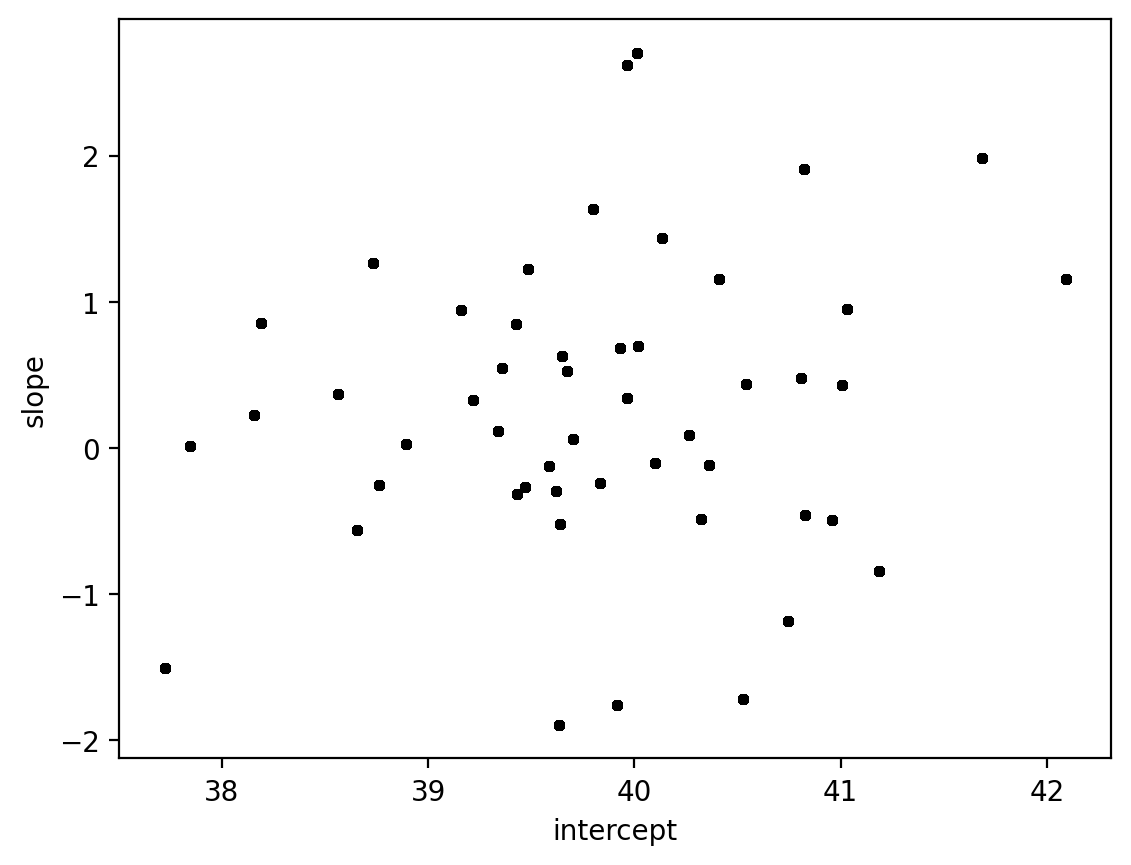

In [40]:
plt.plot(sample[:, 0], sample[:, 1], '.k', alpha=0.01)
plt.xlabel('intercept')
plt.ylabel('slope');

We see a distribution of points near a slope of $\sim 0.45$, and an intercept of $\sim 31$. We'll plot this model over the data below, but first let's see what other information we can extract from this trace.

One nice feature of analyzing MCMC samples is that the choice of nuisance parameters is completely symmetric: just as we can treat the $\{g_i\}$ as nuisance parameters, we can also treat the slope and intercept as nuisance parameters! Let's do this, and check the posterior for $g_1$ and $g_2$, the outlier flag for the first two points:

g1 mean: 0.51
g2 mean: 0.51


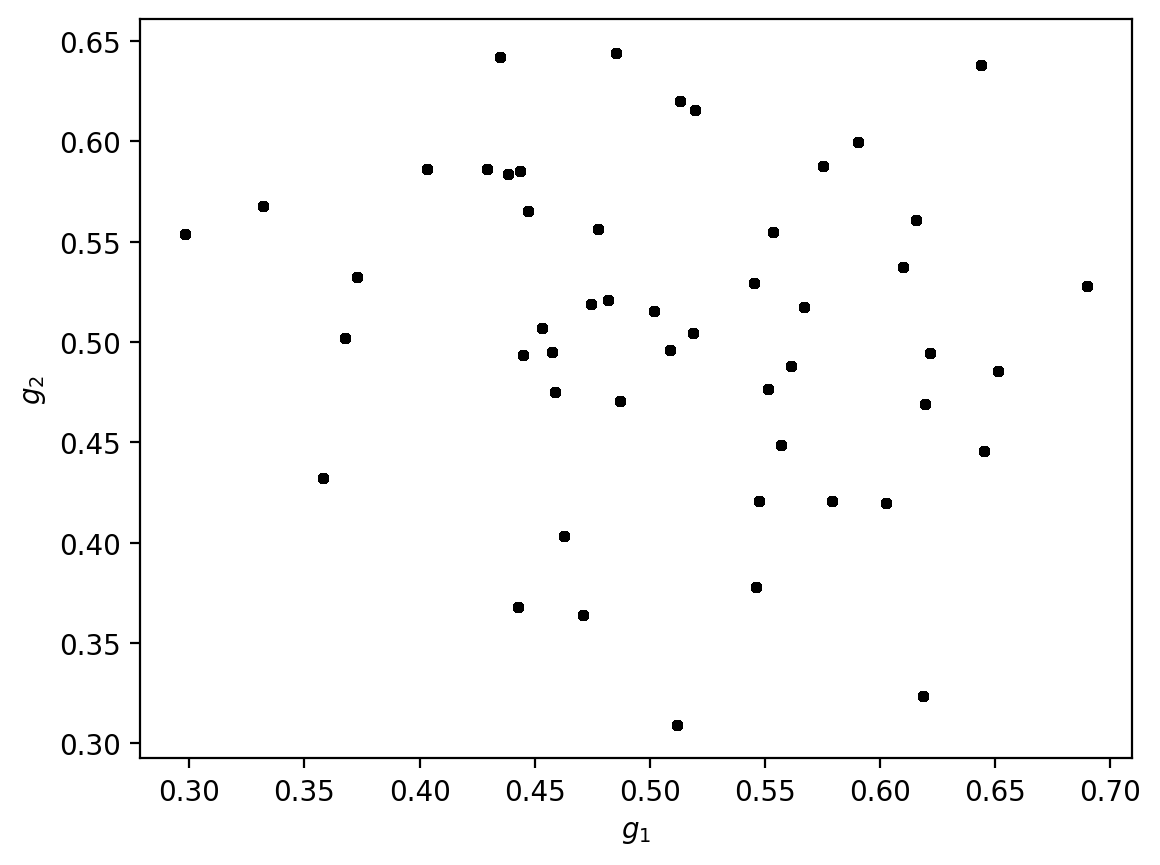

In [41]:
plt.plot(sample[:, 2], sample[:, 3], '.k', alpha=0.01)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))

There is not an extremely strong constraint on either of these, but we do see that $(g_1, g_2) = (1, 0)$ is slightly favored: the means of $g_1$ and $g_2$ are greater than and less than 0.5, respecively. If we choose a cutoff at $g=0.5$, our algorithm has identified $g_2$ as an outlier.

Let's make use of all this information, and plot the marginalized best model over the original data. As a bonus, we'll draw red circles to indicate which points the model detects as outliers:

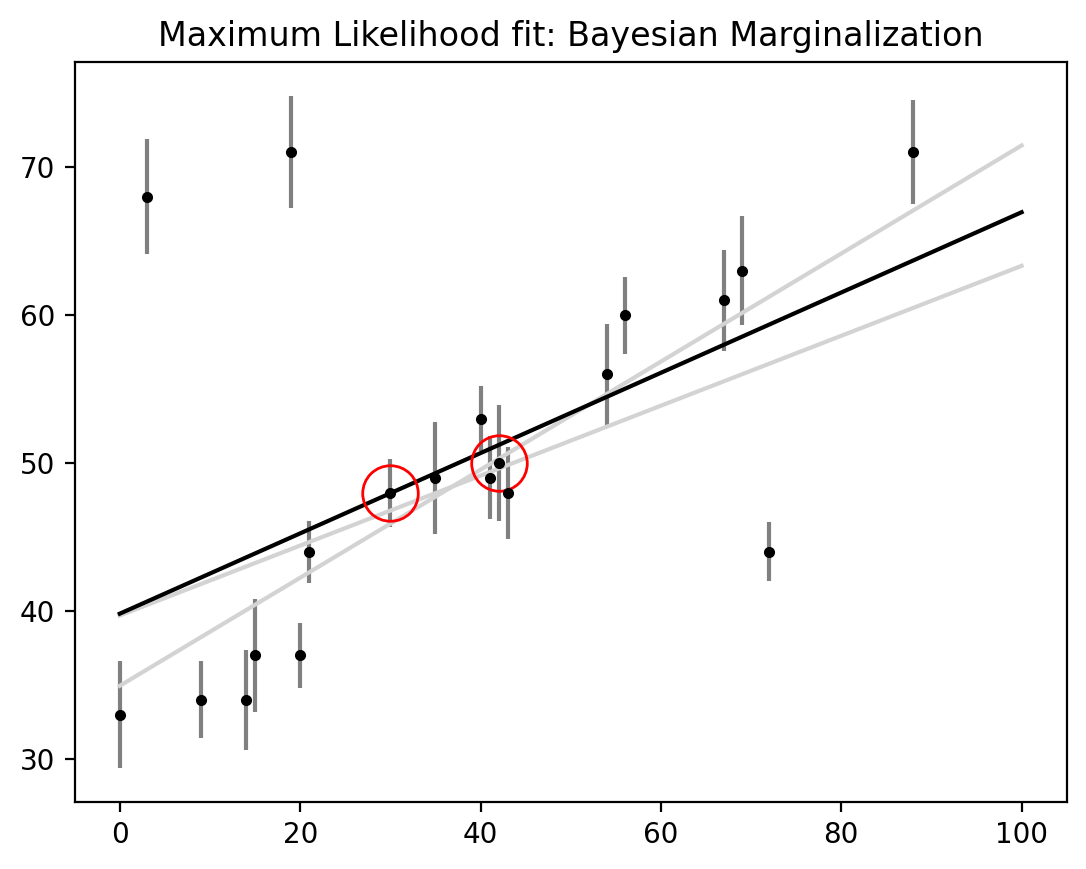

In [53]:
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g > 0.51)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');